In [ ]:
# Notes from lecture 

In [ ]:
# bias variance trade-off with decision trees
# as you increase the number of splits (or the depth), the more we are fitting our data to the train set (variance)

In [ ]:
# adv. of decision trees: good for non linear data, easy to interpret, account for interaction
# disadv. - tend to overfit

In [ ]:
# to get rid of the variance in decision tree models, we can ensemble many models, creating a random forest

In [6]:
# STEPS
# 1. bootstrapping - take subset of original data set WITH replacement (randomness in our observations)
# 2. take subset of our features (create randomness in feature selection)
# 3. aggregate?

In [ ]:
# out of bag error - compare the predicted values from the data you used to the observations you didn't

In [ ]:
# issue with bagging - each model may be correlated so that is why we split features as well

In [ ]:
# adv. of random forest - almost always outperforms decision trees, limits overfitting
# disadv - not as interpretable as decision tress, many hyperparams to tune

## Random Forest

We'll use the Ames Housing Dataset to see the predictive capability of a single decision tree vs a random forest.

For full dataset and documentation:
- http://jse.amstat.org/v19n3/decock/DataDocumentation.txt
- http://jse.amstat.org/v19n3/decock/AmesHousing.txt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

from sklearn.model_selection import train_test_split

#This is for displaying the tree (we shouldn't need these now)
!pip install pydotplus
!pip install GraphViz
import pydotplus as pydot
from IPython.display import Image
import graphviz

    100% |████████████████████████████████| 286kB 5.2MB/s ta 0:00:01
  Stored in directory: /Users/Kristinabarounis/Library/Caches/pip/wheels/35/7b/ab/66fb7b2ac1f6df87475b09dc48e707b6e0de80a6d8444e3628
Successfully built pydotplus


In [2]:
datafile = "Ames_Housing_Data.tsv"

In [3]:
df = pd.read_csv(datafile,sep='\t')

In [4]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [7]:
# Preprocessing as we did last time

df = df.loc[df['Gr Liv Area']<=4000,:]
df = df.loc[:,['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add',
        'Gr Liv Area', 
        'Full Bath', 'Bedroom AbvGr',
        'Fireplaces', 'Garage Cars','SalePrice']]
df = df.fillna(0)

In [8]:
df.head()

,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Gr Liv Area,Full Bath,Bedroom AbvGr,Fireplaces,Garage Cars,SalePrice
0,31770,6,5,1960,1960,1656,1,3,2,2.0,215000
1,11622,5,6,1961,1961,896,1,2,0,1.0,105000
2,14267,6,6,1958,1958,1329,1,3,0,1.0,172000
3,11160,7,5,1968,1968,2110,2,3,2,2.0,244000
4,13830,5,5,1997,1998,1629,2,3,1,2.0,189900


In [9]:
df.columns

Index(['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Gr Liv Area', 'Full Bath', 'Bedroom AbvGr',
       'Fireplaces', 'Garage Cars', 'SalePrice'],
      dtype='object')

In [10]:
df.shape

(2925, 11)

In [11]:
feature_columns = ['Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Gr Liv Area', 'Full Bath', 'Bedroom AbvGr',
       'Fireplaces', 'Garage Cars']

y = df.loc[:,"SalePrice"]
X = df.loc[:,feature_columns]


In [12]:
#Split the data 70-30 train/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

In [13]:
## To start, we will build a single tree
from sklearn import tree

# Set some parameters
dtrmodel = tree.DecisionTreeRegressor(min_samples_split=10, max_depth=6, min_samples_leaf=8)

# Fit the model to some training data
dtrmodel.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=8,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [14]:
dtrmodel.tree_

In [15]:
# Export the structure of the tree to a file

tree.export_graphviz(dtrmodel, out_file='tree.dot',feature_names = X_train.columns)

In [16]:
# Look at the file (using ! for a command line access)

!head tree.dot

digraph Tree {
node [shape=box] ;
0 [label="Overall Qual <= 7.5\nmse = 6032184943.253\nsamples = 2047\nvalue = 179343.2"] ;
1 [label="Overall Qual <= 5.5\nmse = 2381604076.047\nsamples = 1722\nvalue = 156110.018"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Overall Qual <= 4.5\nmse = 1045455934.874\nsamples = 780\nvalue = 125499.932"] ;
1 -> 2 ;
3 [label="Gr Liv Area <= 843.0\nmse = 1061232750.313\nsamples = 198\nvalue = 100637.859"] ;
2 -> 3 ;
4 [label="Overall Qual <= 2.5\nmse = 475925001.778\nsamples = 43\nvalue = 71072.419"] ;


In [20]:
# http://webgraphviz.com 
# Insert tree.dot onto webpage

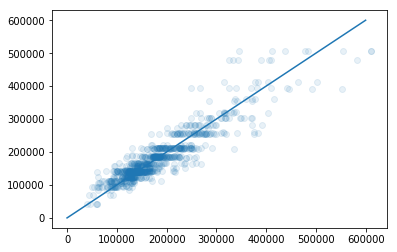

In [21]:
# Now let's predict on the test set and plot pred vs actual

tree_pred_test = dtrmodel.predict(X_test)
plt.scatter(y_test, tree_pred_test,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,600000,1000))


## Comprehension question
Why do we see these horizontal "bands" in the predicted vs actual plot?

In [22]:
# Root Mean Square Error (compared to 34427 for linear regression without OQ2, 29882 with OQ2)
np.sqrt(np.mean((tree_pred_test - y_test)**2))

32681.238995996246

In [53]:
# Not bad for a single tree!  Let's try a Random Forest

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
# Initialize the model, then fit it on the training data
rfmodel1 = RandomForestRegressor(n_estimators = 500, min_samples_leaf=5, max_features=4, n_jobs=-1)
rfmodel1.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [25]:
# Use the trained model to predict the results on the test set

rf1_test_pred = rfmodel1.predict(X_test)

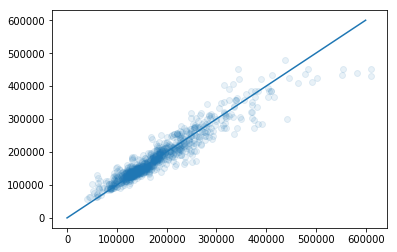

In [26]:
#Plot actual vs predicted
plt.scatter(y_test, rf1_test_pred,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,600000,1000))



In [27]:
# Root Mean Square Error (compared to 34427 for linear regression without OQ2, 29882 with OQ2)
np.sqrt(np.mean((rf1_test_pred - y_test)**2))

25928.937156602344

In [59]:
## Even better!

## now create your own Random Forest model (rfmodel2), choose some new parameters
## e.g. max_features, min_leaf_size, min_sample_size

# Calculate the RMSE for your model

In [36]:
# Initialize the model, then fit it on the training data
rfmodel1 = RandomForestRegressor(n_estimators = 700, min_samples_leaf=3, max_features=7, n_jobs=-1)
rfmodel1.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [37]:
rf1_test_pred = rfmodel1.predict(X_test)

In [39]:
np.sqrt(np.mean((rf1_test_pred - y_test)**2))

25602.342874003458

In [43]:
rf_param_grid = {
'n_estimators': [100,200,500],
'min_samples_leaf':[3,6],
'max_features':[1,2,3,4,5,6,7]
}

In [48]:
rfmodel = RandomForestRegressor()

rf_param_grid = {
'n_estimators': [100,200,500],
'min_samples_leaf':[3,6],
'max_features':[1,2,3,4,5,6,7]
}

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
gs_tree = GridSearchCV(rfmodel, rf_param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

{'max_features': 4, 'min_samples_leaf': 3, 'n_estimators': 100}

In [50]:
gs_pred = gs_tree.predict(X_test)

In [51]:
np.sqrt(np.mean((gs_pred - y_test)**2))

25352.99955687108